# Project: Semantic Textual Similarity




### Mandatory project

https://gebakx.github.io/ihlt/sts/index.html#5

**Statement:**

- Use data set and description of task Semantic Textual Similarity in SemEval 2012.

- Implement some approaches to detect paraphrase using sentence similarity metrics.

  - Explore some lexical dimensions.
  - Explore the syntactic dimension alone.
  - Explore the combination of both previous.

- Add new components at your choice (optional)

- Compare and comment the results achieved by these approaches among them and among the official results.

- Send files to raco in IHLT STS Project before the oral presentation:

  - Jupyter notebook: sts-[Student1]-[Student2].ipynb

  - Slides: sts-[Student1]-[Student2].pdf


## Third Requirements libraries

In [1]:
import tarfile
import nltk
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn

from nltk import CFG, ChartParser
from nltk.book import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from nltk.wsd import lesk
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.corpus import wordnet as wn
from scipy import spatial

# nltk.download() # 1. d | 2. book | 3. q
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')


*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


[nltk_data] Downloading package wordnet to /home/guess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/guess/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/guess/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

## Own Requirements libraries

Here we are gonna  put our codes into modules (python files) to later just import them.

In [84]:
%%time

# !curl -Lo models/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip

from infersent import InferSent

model_version = 2
MODEL_PATH = f'./models_repo/infersent{model_version}.pkl'
# W2V_PATH = './models_repo/glove.840B.300d.txt' # GloVe
W2V_PATH = './models_repo/crawl-300d-2M.vec' # fastText
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}

model_senteval = InferSent(params_model)
model_senteval.load_state_dict(torch.load(MODEL_PATH))
model_senteval.set_w2v_path(W2V_PATH)
model_senteval.build_vocab_k_words(K=100000)

Vocab size : 100000
CPU times: user 4.54 s, sys: 565 ms, total: 5.1 s
Wall time: 5.17 s


# Exploratory Data Analysis

## Download train/test sets


In [ ]:
url_train = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/train.tgz'
url_test = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/test-gold.tgz'

!wget -q $url_train
!wget -q $url_test

with tarfile.open('train.tgz', "r:gz") as tar:
  tar.extractall()
with tarfile.open('test-gold.tgz', "r:gz") as tar:
  tar.extractall()

!echo 'Training' && ls train && echo '\nTesting' && ls test-gold

Training
00-readme.txt	   STS.gs.MSRvid.txt	   STS.input.MSRvid.txt
correlation.pl	   STS.gs.SMTeuroparl.txt  STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.input.MSRpar.txt    STS.output.MSRpar.txt

Testing
00-readme.txt	   STS.gs.SMTeuroparl.txt	STS.input.MSRvid.txt
STS.gs.ALL.txt	   STS.gs.surprise.OnWN.txt	STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.gs.surprise.SMTnews.txt	STS.input.surprise.OnWN.txt
STS.gs.MSRvid.txt  STS.input.MSRpar.txt		STS.input.surprise.SMTnews.txt


## Read and gather metadata

Let's begin working with **MSRvid** data set

In [88]:
train_sents = pd.read_csv('train/STS.input.MSRvid.txt', sep='\t', names=['sent1', 'sent2'])
train_label = pd.read_csv('train/STS.gs.MSRvid.txt', names=['score'])
train_data = pd.concat([train_sents, train_label], axis=1)

test_sents = pd.read_csv('test-gold/STS.input.MSRvid.txt', sep='\t', names=['sent1', 'sent2'])
test_label = pd.read_csv('test-gold/STS.gs.MSRvid.txt', names=['score'])
test_data = pd.concat([test_sents, test_label], axis=1)

print(f' Train data set: ({len(train_data)}, {len(train_data.columns)})')
train_data.head()

 Train data set: (750, 3)


,sent1,sent2,score
0,A man is riding a bicycle.,A man is riding a bike.,5.0
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0
2,Someone is drawing.,Someone is dancing.,0.3
3,A man and a woman are kissing each other.,A man and a woman are talking to each other.,0.6
4,A woman is slicing an onion.,A woman is cutting an onion.,4.2


In [143]:
print(f' Test data set: ({len(test_data)}, {len(test_data.columns)})')
test_data.head()

 Test data set: (750, 11)


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,man hard hat dance,man wear hard hat dance,0.281250,0.357086,0.397059,0.310816,0.972126,0.981522
1,A plane is taking off.,An air plane is taking off.,5.00,plane take,air plane take,0.066667,0.127768,0.111111,0.044784,0.963400,0.971580
2,A young child is riding a horse.,A child is riding a horse.,4.75,young child rid horse,child rid horse,0.019608,0.000000,0.000000,0.000000,0.985212,0.984311
3,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,man feed mouse snake,man feed mouse snake,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,A man is playing a large flute.,A man is playing a flute.,3.80,man play large flute,man play flute,0.666667,0.666667,0.666667,0.666667,0.981777,0.984587


**Check frequency of tokens**

As shown in the result we should deal with stopwords as well as punctuations.


In [90]:
sent1_tokens = train_data['sent1'].apply(nltk.word_tokenize).values
sent2_tokens = train_data['sent2'].apply(nltk.word_tokenize).values

freq_sent1 = FreqDist(np.concatenate(sent1_tokens).ravel())
freq_sent2 = FreqDist(np.concatenate(sent2_tokens).ravel())

print(f'Sentence 1:')
print(freq_sent1.most_common()[:6])

print(f'Sentence 2:')
print(freq_sent2.most_common()[:6])

Sentence 1:
[('.', 747), ('A', 588), ('is', 560), ('a', 396), ('man', 304), ('woman', 178)]
Sentence 2:
[('.', 749), ('A', 623), ('is', 575), ('a', 445), ('man', 302), ('woman', 192)]


In [91]:
train_data.dtypes

sent1     object
sent2     object
score    float64
dtype: object

## Preprocessing

- Cast sentences as type string.
- Deal with stopwords and puntuations
- Tokenize the sentences.
- Tag each word as a Part of speech (POS)
- Lemmatize each word into its root but with sense (different than stemming).


**Casting**



In [ ]:
# train_data[['sent1', 'sent2']] = train_data[['sent1', 'sent2']].astype(str) 
# print(train_data.dtypes)


**Stopwords and puntuations**

In [92]:
# stopwords and punctuations

def get_stopwords():
  stop_words = list(set(stopwords.words('english')))
  stop_words_2 = [w.capitalize() for w in stop_words]
  stop_words_3 = [w.upper() for w in stop_words]

  stop_words_all = stop_words + stop_words_2 + stop_words_3

  return stop_words_all

def remove_stopwords(tokens, rm_punct=False, custom_chars=None):
  
  stop_words_all = get_stopwords()
  result = [w for w in tokens if w not in stop_words_all]

  if rm_punct:
    result = [w for w in result if w not in punctuation]

  if custom_chars is not None:  # custom characters to remove
    result = [w for w in result if w not in custom_chars]

  return result

# Test
s1 = 'A man is riding a bicycle.'
remove_stopwords(nltk.word_tokenize(s1), rm_punct=True)

['man', 'riding', 'bicycle']

**POS**



In [93]:
def map_pos_wordnet(pos):
  d = {"N": wordnet.NOUN, # 'n'
       "V": wordnet.VERB, # 'v'
       "J": wordnet.ADJ, #  'a'
       "R": wordnet.ADV} #  'r'

  return d[pos[0]]

def lemmatize(pairs):
  wnl = WordNetLemmatizer()
  result = []
  for token, pos in pairs:
    if pos[0] in {'N','V', 'J', 'R'}:
      synset = wnl.lemmatize(token.lower(), 
                                     pos=map_pos_wordnet(pos))
      result.append(synset)
    else:
      result.append(token)
  return result

In [94]:
def join_tokens(tokens):
  return ' '.join(tokens)

join_tokens(['a', 'b'])

'a b'

In [95]:
def get_score_infersent(X, tokenize=True):
    eb1 = model_senteval.encode([X[0]], tokenize=tokenize)
    eb2 = model_senteval.encode([X[1]], tokenize=tokenize)

    result = 1 - spatial.distance.cosine(eb1,eb2)


    return result

## Feature engineering

Extract the most meaningful features from the sentences

In [96]:
cols = ['sent1_processed', 'sent2_processed']

**LCS distances + wsd lesk**

There are some distances that do not exist because their synsets postag dont match (e.g n != v). For that case, a zero value is set.



In [97]:
brown_ic = wordnet_ic.ic('ic-brown.dat')

def lcs_distances(X):

  results = []
  for x in X:
    result = []
    context = dict(x).keys()
    for (token, pos) in x:
      # print(token, pos)
      if pos[0] in {'N','V', 'J', 'R'}:
        # synset = lesk(context, token.lower(), pos=map_pos_wordnet(pos))
        synset = wn.synsets(token.lower(), pos=map_pos_wordnet(pos))
        # print(synset)
        # try if synset exists with pos tag
        if len(synset) != 0:
          result.append(synset[0])
        else:
          clean_token = token.lower().translate(str.maketrans('', '', punctuation))
          synset = wn.synsets(clean_token)

          # print(clean_token, synset) 
          if len(synset) != 0:
            result.append(synset[0])
          else: # default synset value
            result.append(wn.synsets('default')[0])
        # try if synset exists without pos tag
      else:
          # calculate lesk without considering pos
        synset = wn.synsets(token.lower())
        if len(synset) != 0:
          # print(token, pos)
          # print('here')
          result.append(synset[0])
        else: # For instance key-board
          clean_token = token.lower().translate(str.maketrans('', '', punctuation))
          synset = wn.synsets(clean_token)
          if len(synset) != 0:
            result.append(synset[0])
          else: # default synset value
            result.append(wn.synsets('default')[0])
          # pass
          # result.append(wn.synsets(''))
    results.append(result)

  # pairs_synsets
  path_sims = []
  lch_sims = []
  wup_sims = []
  lin_sims = []
  for syn1, syn2 in zip(*results):
    
    # print(syn1, syn2)
    ps = syn1.path_similarity(syn2)
    # print('ps', ps)
    try:
      lch = syn1.lch_similarity(syn2)
      lch_normalized = lch/syn1.lch_similarity(syn1)
      wp = syn1.wup_similarity(syn2)
      lin = syn1.lin_similarity(syn2, ic=brown_ic)

      path_sims.append(ps)
      lch_sims.append(lch_normalized)
      wup_sims.append(wp)
      lin_sims.append(lin)
      # return [ps, lch_normalized, wp, lin]
    except:
      if ps is not None:
        path_sims.append(ps)
      else:
        path_sims.append(0)
      lch_sims.append(0)
      wup_sims.append(0)
      lin_sims.append(0)
      # return [ps, 0, 0, 0]
    # average_sim = (0.4*ps + 0.7*lch_normalized + 0.8*wp + 1*lin)/(2.9)

  return np.array([np.mean(path_sims), np.mean(lch_sims), np.mean(wup_sims), np.mean(lin_sims)])

**Apply preprocessing steps**


In [98]:
for col in ['sent1', 'sent2']:
  train_data[col+'_processed'] = train_data[col].apply(nltk.word_tokenize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(nltk.pos_tag)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(lemmatize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(nltk.pos_tag)
  # train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)
  # train_data[col+'_processed'] = train_data[col+'_processed'].apply(core_relationship)
  

train_data.head()

,sent1,sent2,score,sent1_processed,sent2_processed
0,A man is riding a bicycle.,A man is riding a bike.,5.0,"[(man, NN), (rid, JJ), (bicycle, NN)]","[(man, NN), (rid, VBZ), (bike, IN)]"
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,"[(woman, NN), (man, NN), (dance, NN), (rain, NN)]","[(man, NN), (woman, NN), (dance, NN), (rain, NN)]"
2,Someone is drawing.,Someone is dancing.,0.3,"[(someone, NN), (draw, NN)]","[(someone, NN), (dance, NN)]"
3,A man and a woman are kissing each other.,A man and a woman are talking to each other.,0.6,"[(man, NN), (woman, NN), (kiss, VB)]","[(man, NN), (woman, NN), (talk, NN)]"
4,A woman is slicing an onion.,A woman is cutting an onion.,4.2,"[(woman, NN), (slice, NN), (onion, NN)]","[(woman, NN), (cut, NN), (onion, NN)]"


In [99]:
lcs_wsd = train_data[cols].apply(lcs_distances, axis=1).values
lcs_wsd = pd.DataFrame(np.stack(lcs_wsd), columns=['ps', 'lch', 'wup', 'lin'])
train_data = pd.concat([train_data, lcs_wsd], axis=1)
train_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,A man is riding a bicycle.,A man is riding a bike.,5.0,"[(man, NN), (rid, JJ), (bicycle, NN)]","[(man, NN), (rid, VBZ), (bike, IN)]",0.733333,0.852518,0.909091,0.666667
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,"[(woman, NN), (man, NN), (dance, NN), (rain, NN)]","[(man, NN), (woman, NN), (dance, NN), (rain, NN)]",0.666667,0.848992,0.833333,0.893542


**Dependency Trees**

In [100]:
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.metrics.distance import jaro_similarity, jaro_winkler_similarity

parser = CoreNLPDependencyParser(url='http://localhost:9000')

def dp_relationship(sent):

#   results = []
#   for x in X:
#     result = []

    parse = parser.raw_parse(sent)
    tree = next(parse)
    triples = list(tree.triples())
    # print(triples1)
    core_triples = list()
    for (a,b,c) in triples:
      # if b in ['nsubj']:
      core_triples.append(c)
      core_triples.append(a)
      # if b in ['nmod']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
      # elif b in ['dobj']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
    # core_triples1 = [(c, a) for (a,b,c) in triples1 if b in ['nsubj']]
    unique = []
    [unique.append(item) for item in core_triples if item not in unique]

    unique = [item for item in unique if 'V' in item[1] or 'N' in item[1] ]

    return unique


In [110]:
%%time

for col in ['sent1', 'sent2']:
  train_data[col+'_processed'] = train_data[col].apply(nltk.word_tokenize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(nltk.pos_tag)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(dp_relationship)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(lemmatize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(lemmatize)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)

train_data.head(3)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,infer
0,A man is riding a bicycle.,A man is riding a bike.,5.0,rid man bicycle,rid man bike,0.733333,0.852518,0.909091,0.666667,0.988196
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,woman rain man dancing,man rain woman dancing,0.666667,0.848992,0.833333,0.893542,0.997711
2,Someone is drawing.,Someone is dancing.,0.3,someone drawing,someone dancing,0.545455,0.670400,0.616071,0.565121,0.949012


In [111]:
%%time

depen_parsing = train_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing = pd.DataFrame(np.stack(depen_parsing), columns=['dp'])
train_data = pd.concat([train_data, depen_parsing], axis=1)
train_data.head(2)

CPU times: user 1min 39s, sys: 108 ms, total: 1min 39s
Wall time: 1min 40s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,infer,dp
0,A man is riding a bicycle.,A man is riding a bike.,5.0,rid man bicycle,rid man bike,0.733333,0.852518,0.909091,0.666667,0.988196,0.988608
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,woman rain man dancing,man rain woman dancing,0.666667,0.848992,0.833333,0.893542,0.997711,0.994266


**SentEval: sentence embeddings**

This function yields a score from  a pretrained model, based on word embedding.


References:

- Snippet: https://github.com/facebookresearch/InferSent/blob/master/demo.ipynb


- Infersent1: https://drive.google.com/file/d/1pRbvodca415gtrbMJf8EqBf--wOmu9Lf/view?usp=sharing

- Infersent2: https://drive.google.com/file/d/1sfIlbc8C5k_CujTF7UrtW_2lvNIH-EhW/view?usp=sharing

- GloVe: http://nlp.stanford.edu/data/glove.840B.300d.zip

- Fasttext: https://fasttext.cc/docs/en/english-vectors.html


In [ ]:
#!conda install pytorch torchvision cpuonly -c pytorch

In [112]:
for col in ['sent1', 'sent2']:
  train_data[col+'_processed'] = train_data[col].apply(nltk.word_tokenize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(nltk.pos_tag)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(lemmatize)
  train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)

train_data.head(3)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,infer,dp
0,A man is riding a bicycle.,A man is riding a bike.,5.0,man rid bicycle,man rid bike,0.733333,0.852518,0.909091,0.666667,0.988196,0.988608
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,woman man dance rain,man woman dance rain,0.666667,0.848992,0.833333,0.893542,0.997711,0.994266
2,Someone is drawing.,Someone is dancing.,0.3,someone draw,someone dance,0.545455,0.670400,0.616071,0.565121,0.949012,0.956376


In [119]:
%%time

infer_feat = train_data[cols].apply(get_score_infersent, axis=1)
infer_feat = pd.DataFrame(np.stack(infer_feat), columns=['infer'])
train_data = pd.concat([train_data, infer_feat], axis=1)
train_data.head(2)


CPU times: user 1min 41s, sys: 18 ms, total: 1min 41s
Wall time: 1min 41s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,A man is riding a bicycle.,A man is riding a bike.,5.0,man rid bicycle,man rid bike,0.733333,0.852518,0.909091,0.666667,0.988608,0.988196
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,woman man dance rain,man woman dance rain,0.666667,0.848992,0.833333,0.893542,0.994266,0.997711


# Modeling

Try a baseline model with the final features: basically the join of the scores (fom dependency tree, wds, lcs, etc).







In [120]:
train_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,A man is riding a bicycle.,A man is riding a bike.,5.0,man rid bicycle,man rid bike,0.733333,0.852518,0.909091,0.666667,0.988608,0.988196
1,A woman and man are dancing in the rain.,A man and woman are dancing in rain.,5.0,woman man dance rain,man woman dance rain,0.666667,0.848992,0.833333,0.893542,0.994266,0.997711


In [121]:
label = 'score'
features = [col for col in train_data.columns if col not in ['sent1',
                                                             'sent2',
                                                             'sent1_processed',
                                                             'sent2_processed', label]]
X = train_data[features].copy()
y = train_data[label].copy()
X.head()

,ps,lch,wup,lin,dp,infer
0,0.733333,0.852518,0.909091,0.666667,0.988608,0.988196
1,0.666667,0.848992,0.833333,0.893542,0.994266,0.997711
2,0.545455,0.670400,0.616071,0.565121,0.956376,0.949012
3,0.700000,0.666667,0.666667,0.666667,0.966544,0.965816
4,0.777778,0.899328,0.952381,0.896518,0.969697,0.973691


Scaling all the features with mean 0 and  variance 1



In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X) # This scaler will be used for training stage

X_scaled = scaler.transform(X)
X_scaled

array([[ 1.18323415,  1.38163171,  1.57551857,  0.78430307,  1.4622357 ,
         1.45028039],
       [ 0.92769299,  1.36638544,  1.26103385,  1.62937857,  1.61550423,
         1.71021049],
       [ 0.46307271,  0.59420698,  0.3591366 ,  0.40606107,  0.58917887,
         0.37986533],
       ...,
       [-0.87529182, -1.00240112, -1.0148424 , -1.02143676, -0.66109013,
        -1.0396785 ],
       [-0.35001278, -0.86317465, -0.81456529, -0.45731164, -0.98033983,
        -1.0114637 ],
       [-1.29941916, -0.93431276, -0.85231418, -1.60907969, -0.93611198,
        -0.62109228]])

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

test_size = 0.2
seed = 42
X_train, X_val, y_train, y_val = train_test_split(
                X_scaled, y, test_size=test_size, random_state=seed)

X_train

array([[-0.10608713, -0.33423724, -0.16339693, -0.23559656, -0.37275342,
        -0.16818849],
       [ 0.1741742 ,  0.56777252,  0.61309549,  0.63740837, -0.21067452,
        -0.225385  ],
       [-0.00929124, -0.1318443 ,  0.23970729,  0.28896042,  0.75875071,
         0.6998919 ],
       ...,
       [ 1.0075496 ,  0.92078266,  0.86047963,  0.78430307,  0.86112993,
         0.94728426],
       [-1.35129183, -1.11172159, -1.64015374, -1.69892634,  0.19052118,
        -0.10698968],
       [ 0.52840994,  0.74846772,  0.93658719,  0.53193149, -0.5444661 ,
        -0.62639233]])

In [ ]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [199]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor

# params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
#           'learning_rate': 0.01, 'loss': 'ls'}
params = {'n_estimators': [100], 'seed':[seed]}
model = XGBRegressor()
for k, v in model.get_params().items():
    if k not in list(params.keys()):
        params[k] = [v]


scoring = 'r2'
num_folds = 5

kfold = KFold(n_splits=num_folds, random_state=seed)
grid_search_t = GridSearchCV(model, params, n_jobs=-1,
                             verbose=1, cv=kfold, return_train_score=True,
                                         scoring=scoring)
grid_search_t.fit(X_train, y_train)

mean = grid_search_t.cv_results_['mean_test_score'][0]
std = grid_search_t.cv_results_['std_test_score'][0]

name = 'GradientBoostingRegressor'
d = {'name': name, 'mean': round(mean, 3),
                 'std': round(std, 3)}

#Base model

estimator = grid_search_t.best_estimator_

d
# clf.fit(X_train, y_train)
# mse = mean_squared_error(y_test, clf.predict(X_test))
# print("MSE: %.4f" % mse)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


{'name': 'GradientBoostingRegressor', 'mean': 0.638, 'std': 0.029}

In [207]:
estimator.fit(X_scaled, y.values)
estimator

[10:52:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

## Tuning

Search the best hyperparameters

In [ ]:
# !pip install hyperopt, hpsklearn

In [183]:
from hpsklearn import HyperoptEstimator, xgboost_regression, any_regressor, any_preprocessing
from hyperopt import tpe

# estim = HyperoptEstimator(regressor=xgboost_regression('my_clf'),
estim = HyperoptEstimator(regressor=xgboost_regression('my_clf'),                          
#                           preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=80,
                          trial_timeout=300)

estim.fit( X_train, y_train.values )
print(estim.score(X_val, y_val.values))
print(estim.best_model())

[10:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  1.70it/s, best loss: 0.5450839130169012]
[10:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  2.61it/s, best loss: 0.5450839130169012]
[10:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  1.31it/s, best loss: 0.5450839130169012]
[10:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  3.83it/s, best loss: 0.5450839130169012]
[10:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  1.20it/s, best loss: 

In [184]:
best_model_final = estim.best_model()['learner']
best_model_final

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.9435787197217484, colsample_bynode=1,
             colsample_bytree=0.9788735935838796, gamma=0.01828207589799718,
             importance_type='gain', learning_rate=0.00195164560932182,
             max_delta_step=0, max_depth=8, min_child_weight=12, missing=nan,
             n_estimators=4600, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.008417303870082648,
             reg_lambda=3.9591016185199215, scale_pos_weight=1, seed=1,
             silent=None, subsample=0.8300232906261146, verbosity=1)

Once we decide the best model, we need to retrain  the model with all the training set.

In [174]:
# params_new_t = xgb_opt[0]
# params_new_t.update({'n_estimators': 1000})
# model = XGBRegressor()
# params_new = dict()
# # for k, v in model.get_params().items():
# #     params_new[k] = [v]
# for k, v in params_new_t.items():
#     params_new[k] = [v]

# grid_search_t = GridSearchCV(model, params_new, n_jobs=-1,
#                              verbose=1, cv=kfold, return_train_score=True,
#                                          scoring=scoring)
# grid_search_t.fit(X_scaled, y)
# best_model_final = grid_search_t.best_estimator_
# best_model_final

In [204]:
best_model_final.fit(X_scaled, y.values)
best_model_final            

[10:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.9435787197217484, colsample_bynode=1,
             colsample_bytree=0.9788735935838796, gamma=0.01828207589799718,
             importance_type='gain', learning_rate=0.00195164560932182,
             max_delta_step=0, max_depth=8, min_child_weight=12, missing=nan,
             n_estimators=4600, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.008417303870082648,
             reg_lambda=3.9591016185199215, scale_pos_weight=1, seed=1,
             silent=None, subsample=0.8300232906261146, verbosity=1)

## Testing

We need to apply all the preprocessing and feature engineering steps to the test data set.

**LCS + WSD**

In [134]:
for col in ['sent1', 'sent2']:
  test_data[col+'_processed'] = test_data[col].apply(nltk.word_tokenize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(nltk.pos_tag)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(lemmatize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(nltk.pos_tag)
  # train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)
  # train_data[col+'_processed'] = train_data[col+'_processed'].apply(core_relationship)
  

test_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.0,"[(man, NN), (hard, JJ), (hat, WP), (dance, NN)]","[(man, NN), (wear, VB), (hard, JJ), (hat, DT),..."
1,A plane is taking off.,An air plane is taking off.,5.0,"[(plane, NN), (take, VB)]","[(air, NN), (plane, NNS), (take, VBP)]"


In [135]:
lcs_wsd_test = test_data[cols].apply(lcs_distances, axis=1).values
lcs_wsd_test = pd.DataFrame(np.stack(lcs_wsd_test), columns=['ps', 'lch', 'wup', 'lin'])
test_data = pd.concat([test_data, lcs_wsd_test], axis=1)
test_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.0,"[(man, NN), (hard, JJ), (hat, WP), (dance, NN)]","[(man, NN), (wear, VB), (hard, JJ), (hat, DT),...",0.281250,0.357086,0.397059,0.310816
1,A plane is taking off.,An air plane is taking off.,5.0,"[(plane, NN), (take, VB)]","[(air, NN), (plane, NNS), (take, VBP)]",0.066667,0.127768,0.111111,0.044784


**Dependency trees**

In [136]:
%%time

for col in ['sent1', 'sent2']:
  test_data[col+'_processed'] = test_data[col].apply(nltk.word_tokenize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(join_tokens)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(nltk.pos_tag)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(dp_relationship)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(lemmatize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(join_tokens)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(lemmatize)
#   train_data[col+'_processed'] = train_data[col+'_processed'].apply(join_tokens)

test_data.head(3)

CPU times: user 14.2 s, sys: 423 ms, total: 14.6 s
Wall time: 1min 32s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,man dancing hat,wear man dancing hat,0.281250,0.357086,0.397059,0.310816
1,A plane is taking off.,An air plane is taking off.,5.00,plane taking,plane take air,0.066667,0.127768,0.111111,0.044784
2,A young child is riding a horse.,A child is riding a horse.,4.75,child rid horse,rid child horse,0.019608,0.000000,0.000000,0.000000


In [137]:
%%time

depen_parsing_test = test_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing_test = pd.DataFrame(np.stack(depen_parsing_test), columns=['dp'])
test_data = pd.concat([test_data, depen_parsing_test], axis=1)
test_data.head(2)

CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 31s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.0,man dancing hat,wear man dancing hat,0.281250,0.357086,0.397059,0.310816,0.972126
1,A plane is taking off.,An air plane is taking off.,5.0,plane taking,plane take air,0.066667,0.127768,0.111111,0.044784,0.963400


**SentEval word embedding**


In [138]:
%%time

for col in ['sent1', 'sent2']:
  test_data[col+'_processed'] = test_data[col].apply(nltk.word_tokenize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(remove_stopwords, 
                                                                    rm_punct=True)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(nltk.pos_tag)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(lemmatize)
  test_data[col+'_processed'] = test_data[col+'_processed'].apply(join_tokens)

infer_feat_test = test_data[cols].apply(get_score_infersent, axis=1)
infer_feat_test = pd.DataFrame(np.stack(infer_feat_test), columns=['infer'])
test_data = pd.concat([test_data, infer_feat_test], axis=1)
test_data.head(2)                                                

CPU times: user 1min 34s, sys: 7.26 ms, total: 1min 34s
Wall time: 1min 34s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.0,man hard hat dance,man wear hard hat dance,0.281250,0.357086,0.397059,0.310816,0.972126,0.981522
1,A plane is taking off.,An air plane is taking off.,5.0,plane take,air plane take,0.066667,0.127768,0.111111,0.044784,0.963400,0.971580


In [139]:
X_test = test_data[features].copy()
y_test = test_data[label].copy()
print(len(X_test))
X_test.head()

750


,ps,lch,wup,lin,dp,infer
0,0.281250,0.357086,0.397059,0.310816,0.972126,0.981522
1,0.066667,0.127768,0.111111,0.044784,0.963400,0.971580
2,0.019608,0.000000,0.000000,0.000000,0.985212,0.984311
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.666667,0.666667,0.666667,0.666667,0.981777,0.984587


**Scaling**

In [140]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-0.54965431, -0.76047294, -0.55002815, -0.54118683,  1.01578855,
         1.26796703],
       [-1.3721774 , -1.75197984, -1.7370538 , -1.53211258,  0.77943903,
         0.99636543],
       [-1.5525594 , -2.3044135 , -2.19829805, -1.69892634,  1.37027329,
         1.34415251],
       ...,
       [-1.28699702, -0.8620756 , -0.45597389, -0.93892809, -2.39806082,
        -2.49509654],
       [-1.4147676 , -1.57308315, -1.32436157, -1.69892634, -1.34660563,
        -1.274227  ],
       [-1.3469041 , -1.20917208, -0.92987635, -1.24845432, -1.21460018,
        -1.18490132]])

With tunning

In [205]:
y_pred = best_model_final.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.8193848744629275


Without tuning

In [208]:
y_pred = estimator.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.8258677130097921


old score

In [590]:
y_pred = best_model.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.8183213591853379


## Feature importance

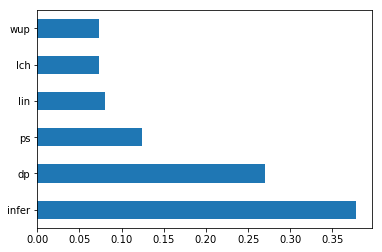

In [214]:
import matplotlib.pyplot as plt

(pd.Series(best_model_final.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh')) 
plt.show()

# Conclusions





